<a href="https://colab.research.google.com/github/adhilcodes/DTTE_projects/blob/main/DTTE_assignment_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 3 - Applying Bayes Classifiers

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1TuDbIyso6irdyBFgaHRpC-PxUICWPHcS?usp=sharing"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Foundations-in-Modern-Machine-Learning/course-contents/tree/main/Bayesian/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

In [20]:
import os
import json
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import tensorflow as tf
import tensorflow_probability as tfp

In [21]:
!wget https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
plt.style.use('ggplot')

--2023-10-11 10:44:05--  https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72422946 (69M) [text/plain]
Saving to: ‘arxiv-paper-data.json.1’

arxiv-paper-data.js 100%[===================>]  69.07M   222MB/s    in 0.3s    

2023-10-11 10:44:06 (222 MB/s) - ‘arxiv-paper-data.json.1’ saved [72422946/72422946]



Let's make a few assumptions to come up with our first general model for classification:
* The different features contribute equally to the result
* The features are independent

## Bayes Classifiers in Scikit Learn

### Simple 1-D Classfication using Naive Bayes in Continuous Space

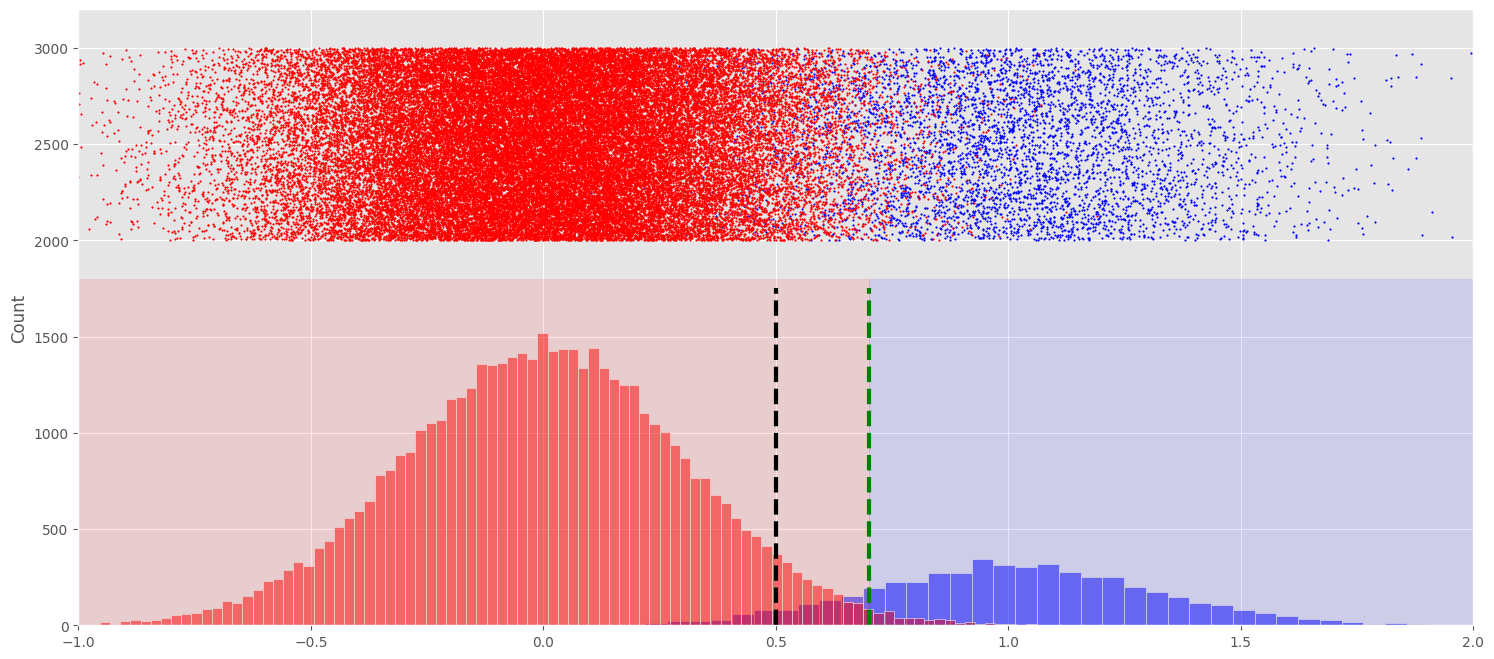

In [22]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.3, size=5000)
x2 = np.random.normal(0.0, 0.3, size=50000)
x = np.concatenate([x1, x2])
y = np.concatenate([np.zeros(len(x1)), np.ones(len(x2))])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, 0.7, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.7, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.7, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

In [23]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
x_reshaped = x.reshape(1, -1)
print(x_reshaped.shape)

(1, 55000)


## Gaussian Bayes Predictor on Predicting Flowers

### Predictors in Scikit Learn

In [24]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_iris(return_X_y=True)
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

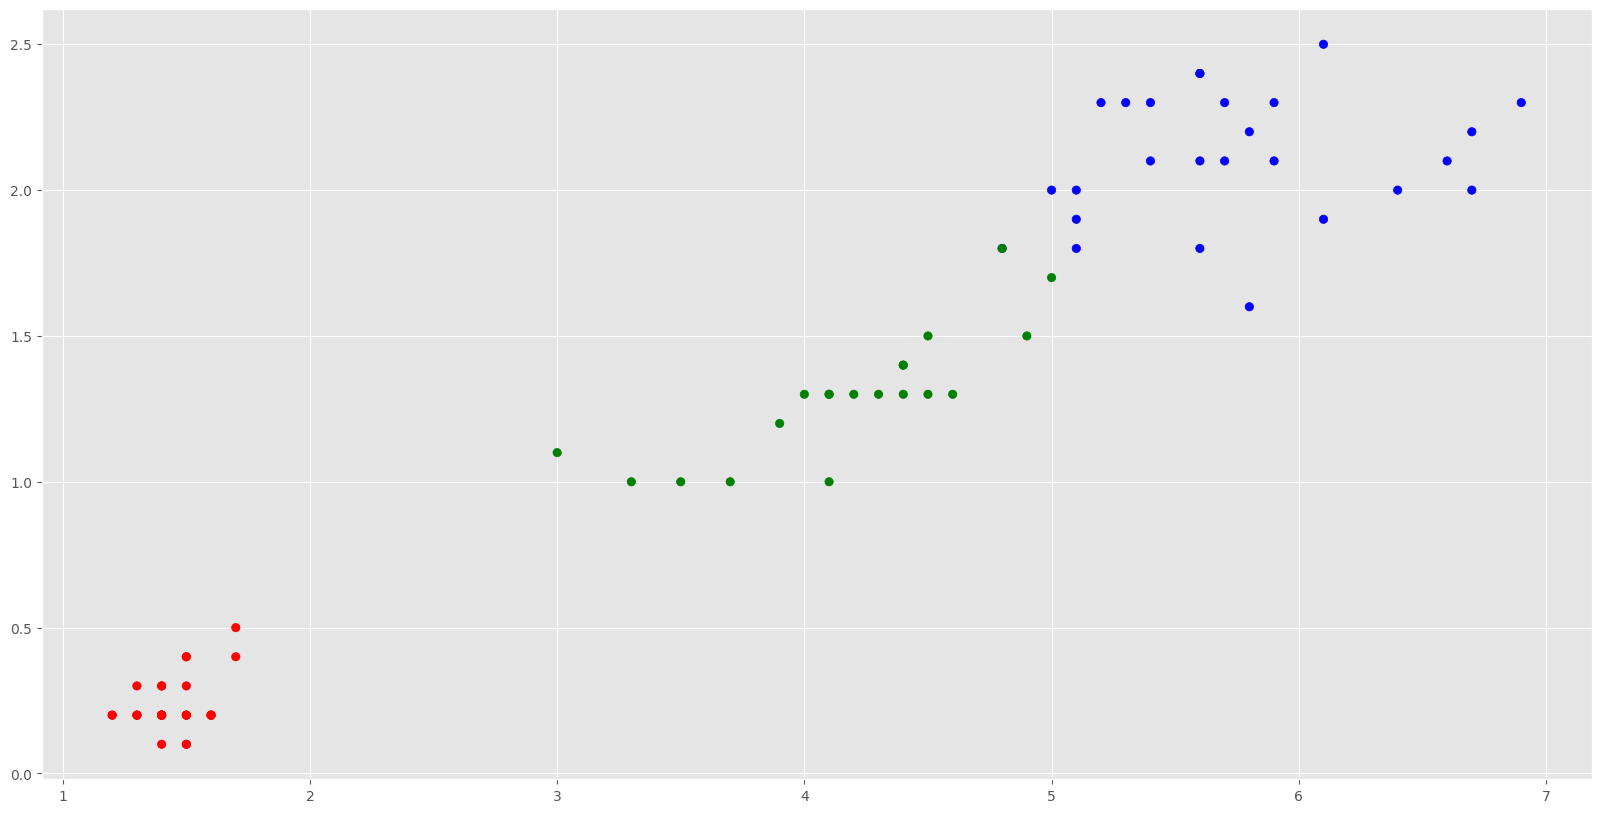

In [25]:
plt.figure(figsize=(20, 10))
color_scheme = ['red', 'green', 'blue']
plt.scatter(X_train[:, 0], X_train[:, 1], c=[color_scheme[idx] for idx in y_train])
plt.show()

### Visualizing the Decision Surface

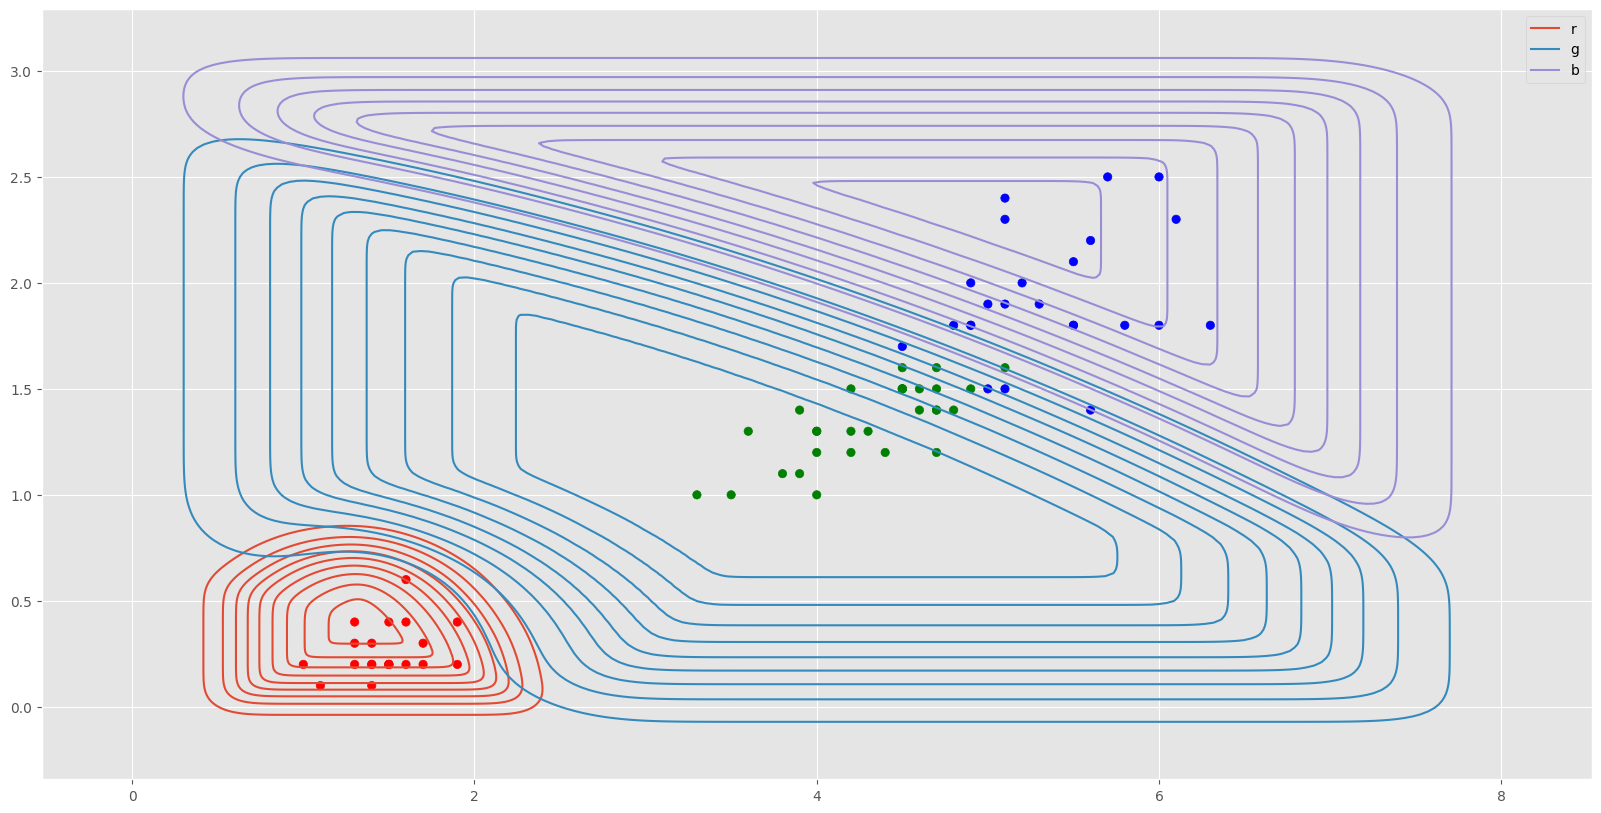

In [26]:
plt.figure(figsize=(20, 10))
X1_scan, X2_scan = np.meshgrid(np.linspace(0.5, 7.5, 250), np.linspace(0.0, 3.0, 250))
X_scan = np.stack([np.reshape(X1_scan, -1), np.reshape(X2_scan, -1)], axis=-1)
predictions = gnb.predict(X_scan)
color_map = ['r', 'g', 'b']
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=[color_map[x] for x in y_test])
sns.kdeplot(x=X_scan[:, 0], y=X_scan[:, 1], hue=[color_map[x] for x in predictions], fill=False)
plt.show()

## Bayes on Text - Classifying papers at Arxiv

### Data Cleaning and Preprocessing

In [44]:
arxiv_df = pd.read_json(open("arxiv-paper-data.json", 'r'))
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: json.loads(x.replace("\'", "\"").replace("None", "\"None\""))[0]['term'].split('.')[0])
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: 'physics' if x in ['physics', 'quant-ph', 'astro-ph', 'hep-ex', 'hep-ph', 'hep-lat', 'hep-th', 'nucl-th'] else x)
arxiv_df = arxiv_df.drop(["day", "month", "link", "author"], axis=1)

In [46]:
SAMPLES_COMP = 1943 #@param {type: "slider", min: 1000, max: 4500}
SAMPLES_STAT = 1951 #@param {type: "slider", min: 1000, max: 4500}
WORD_COUNT_THRESHOLD = 1  #@param {type: "slider", min: 1, max: 500}
WORD_LENGTH_THRESHOLD = 5  #@param {type: "slider", min: 4, max: 20}

In [47]:
df = pd.concat([arxiv_df[arxiv_df['tag'] == 'cs'].sample(SAMPLES_COMP, replace=False),
                arxiv_df[arxiv_df['tag'] == 'stat'].sample(SAMPLES_STAT, replace=False)]).sample(frac=1)
df['keywords'] = df.apply(lambda x: [word.lower() for word in re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', x.summary + ' ' + x.title)).split()
                                     if len(word) > WORD_LENGTH_THRESHOLD and not re.search('(\d|\(|\))', word)], axis=1)
train_df, test_df = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]

print(train_df.shape)
train_df.head()

(3115, 6)


,id,summary,tag,title,year,keywords
6302,1611.01541v1,Although much progress has been made in classi...,stat,Classification with Ultrahigh-Dimensional Feat...,2016,"[although, progress, classification, dimension..."
4086,1305.6650v1,Sensory inference under conditions of uncertai...,cs,Active Sensing as Bayes-Optimal Sequential Dec...,2013,"[sensory, inference, conditions, uncertainty, ..."
14338,cs/9809113v1,We present a bootstrapping method to develop a...,cs,Improving Tagging Performance by Using Voting ...,1998,"[present, bootstrapping, method, develop, anno..."
16074,1609.04253v1,Machine transliteration is the process of auto...,cs,Neural Machine Transliteration: Preliminary Re...,2016,"[machine, transliteration, process, automatica..."
16493,1703.03640v1,Compositionality in language refers to how muc...,cs,A Study of Metrics of Distance and Correlation...,2017,"[compositionality, language, refers, meaning, ..."


In [48]:
df['keywords']

6302     [although, progress, classification, dimension...
4086     [sensory, inference, conditions, uncertainty, ...
14338    [present, bootstrapping, method, develop, anno...
16074    [machine, transliteration, process, automatica...
16493    [compositionality, language, refers, meaning, ...
                               ...                        
33350    [recently, proven, evolutionary, algorithms, p...
1348     [hierarchical, feature, extractors, convolutio...
22945    [compression, neural, networks, become, highly...
11475    [classification, predicting, labels, objects, ...
1888     [interventional, clinical, cancer, trials, gen...
Name: keywords, Length: 3894, dtype: object

### Learning Probability Distributions

In [49]:
from collections import defaultdict

dictionary = defaultdict(lambda: [0, 0])
for desc, tag in zip(df['keywords'], df['tag']):
    for word in set(desc):
        if tag == 'cs':
            dictionary[word][0] += 1
        else:
            dictionary[word][1] += 1

print("We have a dictionary of", len(dictionary), "words.")

words, counts_cs, counts_stat = [], [], []
for word, count in dictionary.items():
    if count[0] + count[1] > WORD_COUNT_THRESHOLD:
        words.append(word)
        counts_cs.append(count[0])
        counts_stat.append(count[1])
print("Out of those", len(words), f"have over {WORD_COUNT_THRESHOLD} occurances")

fig = pg.Figure([pg.Bar(x=words[:200], y=counts_cs[:200]),
                 pg.Bar(x=words[:200], y=counts_stat[:200])])
fig.update_layout(title_text=f'Some random words and the frequency plot of those with over {WORD_COUNT_THRESHOLD} occurances')
fig.show()

We have a dictionary of 13081 words.
Out of those 7164 have over 1 occurances


For each word, for both the subjects, we can apply Bayes rule.

$$P\bigg(\frac{\text{subject}}{\text{word}}\bigg) = P\bigg(\frac{\text{word}}{\text{subject}}\bigg) \times \frac{P(\text{subject})}{P(\text{word})}$$

### Computing the resultant probabilities

In [50]:
prior = np.array([train_df["tag"].value_counts()["cs"], train_df["tag"].value_counts()["stat"]]) / len(train_df)
evidence = np.array([counts_cs / train_df["tag"].value_counts()["cs"], counts_stat / train_df["tag"].value_counts()["stat"]]).T
likelihood = (np.array(counts_cs) + np.array(counts_stat)) / len(train_df)

prior.shape, likelihood.shape, evidence.shape

((2,), (7164,), (7164, 2))

In [51]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(
        np.multiply(this_counts.reshape(-1, 1), evidence), likelihood.reshape(-1, 1))) + 0.001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.8985879332477535


### Visualizing a few examples

In [34]:
def explain(example):
    from IPython.display import HTML
    title, desc, answer = example["title"], example["summary"], example["tag"]
    html = ""
    title = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', title)))
    desc = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', desc)))
    for text in [title, desc]:
        for word in text.split():
            idx = words_to_index[word.lower()]
            if idx == -1:
                html += f"<span style=''>{word}</span> "
            else:
                posterior = np.multiply(evidence[idx], prior)
                posterior /= np.sum(posterior)
                if posterior[0] > posterior[1] if answer == 'cs' else (posterior[0] <= posterior[1]):
                    color = max(0.3, posterior[0] - posterior[1])
                    html += f"<span style='background-color:rgba(0, 255, 0, {color});'>{word}</span> "
                else:
                    color = max(0.3, posterior[1] - posterior[0])
                    html += f"<span style='background-color:rgba(255, 0, 0, {color});'>{word}</span> "
        html += "<br/><br/>"
    return HTML(html)

In [35]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [36]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

In [37]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [38]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

### Visualizing the Learnt Words

In [39]:
print("Some Computer Science words are:")
for word_cs in np.argsort(evidence[:, 0] - evidence[:, 1])[-10:]:
    print(f"\t{words[word_cs]} ({evidence[word_cs, 0]})")
print()
print("Some Statistics words are:")
for word_st in np.argsort(evidence[:, 1] - evidence[:, 0])[-10:]:
    print(f"\t{words[word_st]} ({evidence[word_st, 1]})")

Some Computer Science words are:
	representation (0.12283236994219653)
	architecture (0.08236994219653179)
	challenging (0.09790462427745665)
	segmentation (0.07658959537572255)
	experimental (0.1416184971098266)
	information (0.24241329479768786)
	detection (0.12536127167630057)
	different (0.2666184971098266)
	convolutional (0.12608381502890173)
	recognition (0.1282514450867052)

Some Statistics words are:
	variational (0.09990157480314961)
	variables (0.12992125984251968)
	algorithm (0.39665354330708663)
	theoretical (0.14616141732283464)
	estimation (0.16486220472440946)
	statistical (0.1530511811023622)
	distribution (0.171751968503937)
	inference (0.1934055118110236)
	dimensional (0.18405511811023623)
	regression (0.17716535433070865)


## Probability Smoothing

Probability smoothing is a language modeling technique that assigns some non-zero probability to events that were unseen in the training data. This has the effect that the probability mass is divided over more events, hence the probability distribution becomes more smooth.

### Realizing the Problem

In [40]:
posterior = np.multiply(np.divide(evidence, np.reshape(likelihood, (-1, 1))), np.reshape(prior, (1, -1)))

fig = pg.Figure([pg.Bar(x=words, y=evidence[:20, 0]),
                 pg.Bar(x=words, y=posterior[:20, 0])])
fig.update_layout(title_text='Evidence and Posterior for each word')
fig.show()

In [41]:
print("Some words which never appear in Computer Science paper:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_cs) == 0)[0][:20]]))
print("Some words which never appear in Statistics papers:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_stat) == 0)[0][:20]]))

Some words which never appear in Computer Science paper:
	autocorrelation
	chebyshev
	emphsparse
	poisoning
	confounder
	dependences
	eigenspaces
	differentiates
	exchangeability
	blockmodels
	elucidate
	sparsistency
	uncollapsed
	maximizer
	underdetermined
	archetypal
	archetypes
	frequentist
	transformative
	lauritzen
Some words which never appear in Statistics papers:
	transactional
	trustworthy
	distantly
	exhaustion
	visuomotor
	reverting
	occlusions
	soliciting
	experienced
	contestants
	strategic
	declarative
	navigation
	rectification
	relocalisation
	coordinated
	television
	pertinence
	surroundings
	mastering


Notice the fact that there are cases where the Evidence $P\big(\frac{\text{word}}{\text{subject}}\big) \rightarrow 0$. This is because there are occurances of the given word in the corpus (all the abstract of papers put together) of that subject.

However, this is no way implies that if a word (eg. Employment) never occurs in our training corpus in a Computer Science paper, it will also never occur in a paper in the test set.

Therefore, setting $P(\text{word} | \text{subject}) = 0$ is incorrect, since it will make the posterior $P(\text{subject} | \text{word}) = 0$, even if the corresponding count it 0, we need to come up with a smoother formulation of the Evidence variables.

### Laplace Smoothing



https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece


3.0950170225936245e-05


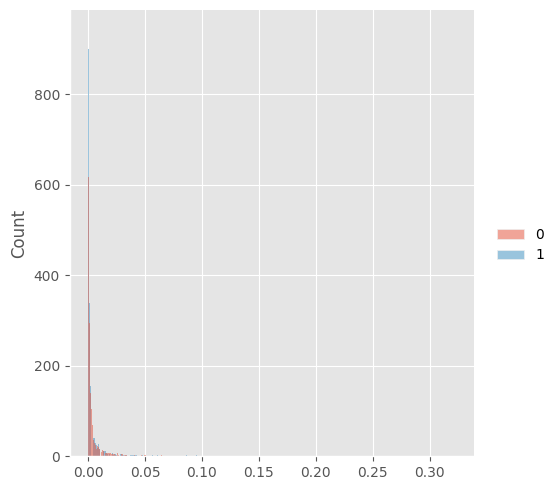

In [42]:
alpha = 0.1
counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                            (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
print(np.min(evidence_smooth))
sns.displot(evidence_smooth)

In [43]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.77


# **Questions**

1. In the "Bayes on Text - Classifying papers at Arxiv" section, what preprocessing steps are performed on the Arxiv paper data? Why are these steps necessary?

2. How are probability distributions learned from the Arxiv paper data, and how are these distributions used in the classification of papers into Computer Science (CS) and Statistics (Stat) categories?

3. What is probability smoothing, and why is it necessary in the context of the Bayesian classifier used in this code? How does Laplace smoothing improve the model's performance, and what parameter is involved in Laplace smoothing?

4. The code uses Laplace smoothing with a fixed value of alpha = 0.1. How might you experiment with different values of alpha to observe the impact on classification accuracy? Provide an example of how you would modify the code to test various alpha values.

5. In the "Visualizing the Decision Surface" section, the code visualizes the decision boundary for the Gaussian Naive Bayes classifier. How would you adjust the code to change the size or color of the decision boundary line, and what significance might these changes have?

# Answers

### Questions 1

  * Some physics related categories are mapped to 'physics'.
  * Unwanted columns, are dropped - "day", "month", "link" and "author".
  * The dataset is sampled to balance the number of samples from the "cs" and "stat" categories.
  * Data is cleaned by removing non-alphanumeric characters and splitting it into words.

### Questions 2

Probability distributions are learned from the Arxiv paper data as follows:

  * Conditional probabilities of the word appearing in a "cs" paper or a "stat" paper using Bayes' rule.
    
  * Prior probabilities calculated based on the training data.
    
  * The evidence probabilities calculated for both categories(considering word's frequency)

### Questions 3

* Probability smoothing is a technique used to assign some non-zero probability to events that were not seen in the training data.

* Laplace smoothing is a type of probability smoothing. It involves adding a alpha value to the counts of each event to ensure that no event has a probability of zero.

* In this case, Laplace smoothing not performed that much, but usually it improves the model's performance.

### Questions 4



In [ ]:
alphas = [0.0001, 0.01, 1.0]

for alpha in alphas:
  counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
  evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                              (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
  print(np.min(evidence_smooth))
  sns.displot(evidence_smooth)

In [62]:
alphas = [0.0001, 0.01, 1.0]

accuracy_results = {}

for alpha in alphas:
    counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
    evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                                (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T

    correct, total = 0, 0
    answers = []

    for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
        this_counts = np.zeros(len(words))
        for word in keywords:
            idx = words_to_index[word]
            if idx != -1:
                this_counts[idx] = 1

        marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
        joint = np.sum(np.log(marginal), axis=0)
        predicted = 'cs' if joint[0] > joint[1] else 'stat'
        answers.append(predicted)

        if predicted == tag:
            correct += 1
        total += 1

    accuracy = correct / total

    accuracy_results[alpha] = accuracy

    print(f"Alpha = {alpha}: Accuracy = {accuracy}")

Alpha = 0.0001: Accuracy = 0.8998716302952503
Alpha = 0.01: Accuracy = 0.8973042362002568
Alpha = 1.0: Accuracy = 0.858793324775353


### Questions 5


`ax.vlines(0.5, 0, 1750, color="purple", linestyles="--", lw=2a) `

`ax.vlines(0.7, 0, 1750, color="green", linestyles="--", lw=1)  `

* 'color' : Changes the color
* 'line width : Adjust width of the line.